<!DOCTYPE html>
<html>
<head>
    <style>
        table {
            width: 50%;
            border-collapse: collapse;
            margin: 20px auto;
        }
        th, td {
            border: 1px solid #dddddd;
            text-align: left;
            padding: 15px;
        }
        th {
            background-color: #f2f2f2;
        }
    </style>
</head>
<body>
<center>
<img src="https://hcmut.edu.vn/img/nhanDienThuongHieu/bk_name_en.png" alt="hcmut logo"/>

<table>
    <tr>
        <th>Role</th>
        <th>Name</th>
        <th>ID</th>
    </tr>
    <tr>
        <td>Institution</td>
        <td>Ho Chi Minh University of Technology</td>
        <td></td>
    </tr>
    <tr>
        <td>Mentor</td>
        <td>Vo Thanh Hung</td>
        <td></td>
    </tr>
    <tr>
        <td>Actor</td>
        <td>Doan Tran Cao Tri</td>
        <td>2010733</td>
    </tr>
    <tr>
        <td></td>
        <td>A</td>
        <td>2</td>
    </tr>
    <tr>
        <td></td>
        <td>B</td>
        <td>2</td>
    </tr>
</table>

</center>
</body>
</html>


### Setup and Import

In [ ]:
# Snippet code below followed by Filemon from https://www.kaggle.com/discussions/general/74235
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download 'adityajn105/flickr8k'

mkdir: cannot create directory ‘/root/.kaggle’: File exists
flickr8k.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!pip install datasets evaluate -q
!pip install jiwer -q
!pip install -U accelerate -q
!pip install -U transformers -q

In [ ]:
!unzip -q "flickr8k.zip"

replace Images/1000268201_693b08cb0e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import pandas as pd
from datasets import Dataset
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
# Read the text file into a pandas DataFrame
df = pd.read_csv('captions.txt')
df = df.sample(frac=1).reset_index(drop=True)
df

,image,caption
0,2199250692_a16b0c2ae1.jpg,A man pulling around some odd thing on wheels .
1,3229282764_a4a515f4e2.jpg,A girl runs down a beach .
2,3138433655_ea1d59e5b7.jpg,A group of young people doing a pose .
3,2667783499_3a4f38f636.jpg,A small boy in blue crawls along a window sill .
4,3560977956_e08d2cd531.jpg,The woman is sitting in the boat being rowed b...
...,...,...
40450,1034276567_49bb87c51c.jpg,A child biting into a baked good .
40451,3535284878_f90f10236e.jpg,A white dog with a black harness runs on a roc...
40452,3559425864_0462d7613f.jpg,Bicyclist ride the course near the ocean as th...
40453,745966757_6d16dfad8f.jpg,A young girl with rollerblades and green folia...


In [ ]:
# # Group the captions by image
# grouped_data = df.groupby('image')['caption'].apply(list).reset_index(name='captions')
# grouped_data

In [ ]:
# Function to load images (adjust the loading function based on your requirements)
def load_image(image_paths):
    return [Image.open(f"Images/{image_path}") for image_path in image_paths]

# Create the dataset
ds = Dataset.from_pandas(df)

# Add the 'image' column to the dataset
ds = ds.map(lambda example: {'image': load_image(example['image'])}, batched=True, batch_size=16)

ds

Map:   0%|          | 0/40455 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'caption'],
    num_rows: 40455
})

In [ ]:
ds = ds.select(range(2000))

In [ ]:
# Split ds to train/test with 0.3
ds = ds.train_test_split(test_size=0.3)
train_ds = ds["train"]
test_ds = ds["test"]

train_ds, test_ds

(Dataset({
     features: ['image', 'caption'],
     num_rows: 1400
 }),
 Dataset({
     features: ['image', 'caption'],
     num_rows: 600
 }))

In [ ]:
train_ds[0]

{'image': {'bytes': None, 'path': 'Images/3724150944_fc62e8d5e0.jpg'},
 'caption': 'Four boys playing soccer .'}

### Preprocessing

In [ ]:
from transformers import AutoProcessor

checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)
processor

GitProcessor:
- image_processor: CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "processor_class": "GitProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

- tokenizer: BertTokenizerFast(name_or_path='microsoft/git-base', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False,

Processor for both inputs are images and texts. Which using CLIPImageProcessor for images and BertTokenizerFast for texts

In [ ]:
def transforms(example_batch):
    images = [Image.open(x['path']) for x in example_batch["image"]]
    captions = [x for x in example_batch["caption"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs

In [ ]:
train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

In [ ]:
train_ds[0].keys()

dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'labels'])

### Base model

In [ ]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/torch/distributed/distributed_c10d.py:347: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


In [ ]:
model

GitForCausalLM(
  (git): GitModel(
    (embeddings): GitEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(1024, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (image_encoder): GitVisionModel(
      (vision_model): GitVisionTransformer(
        (embeddings): GitVisionEmbeddings(
          (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
          (position_embedding): Embedding(197, 768)
        )
        (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (encoder): GitVisionEncoder(
          (layers): ModuleList(
            (0-11): 12 x GitVisionEncoderLayer(
              (self_attn): GitVisionAttention(
                (k_proj): Linear(in_features=768, out_features=768, bias=True)
                (v_proj): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
import numpy as np

def preprocess_logits_for_metrics(logits, labels):
    if isinstance(logits, tuple):
       return logits
    pred_ids = torch.argmax(logits, dim=-1)
    return pred_ids, labels

In [ ]:
from evaluate import load
import torch

wer = load("wer")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted, labels = preprocess_logits_for_metrics(logits, labels)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.20.1`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer

# Training

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
from transformers import TrainingArguments, Trainer

model_name = checkpoint.split("/")[1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-flickr8k",
    learning_rate=5e-5,
    num_train_epochs=50,
    fp16=True, # True if GPU else False
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,
    save_total_limit=5,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    logging_strategy="steps",
    logging_steps=50,
    remove_unused_columns=False,
    push_to_hub=False,
    label_names=["labels"],
    load_best_model_at_end=True,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Wer Score
50,7.114700,4.257147,1.803492
100,2.012600,0.283577,6.577424
150,0.113500,0.069973,8.001378
200,0.050100,0.067654,10.451218
250,0.033500,0.068245,10.812529
300,0.022200,0.071887,12.210752
350,0.014100,0.074315,9.185633
400,0.008400,0.077360,10.007352
450,0.005900,0.079654,10.657528
500,0.004200,0.081749,10.687548


KeyboardInterrupt: ignored

# Prediction

In [ ]:
import torch
from PIL import Image

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

a brown and white dog jumps over an obstacle course.


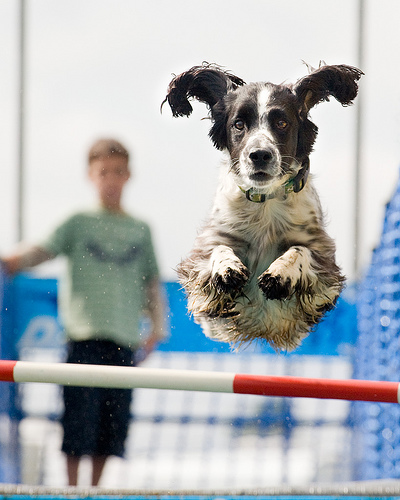

In [ ]:
def run(image):
  inputs = processor(images=image, return_tensors="pt").to(device)
  generated_ids = model.generate(pixel_values=inputs.pixel_values, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  return generated_caption

image = Image.open("Images/2853743795_e90ebc669d.jpg")
print(run(image))
image

# Save model

In [ ]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the save path within your Drive
save_path = '/content/drive/MyDrive/NLP-Thầy Hùng/ModelHub/MicrosoftGit-flickr8k-gen1.ckpt'

# Save the model
trainer.save_model(save_path)